In [1]:
import numpy as np
np.set_printoptions(suppress=True, precision=6)

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
def plot_result(y_test, y_pred, idxs):
    x_range = np.arange(idxs[0], idxs[1])
    plt.plot(x_range, y_test[idxs[0]:idxs[1]], color='red', label='Ground Truth')
    plt.plot(x_range, y_pred[idxs[0]:idxs[1]], color='blue', label='Predicted')
    plt.legend(loc='upper left')

## Подготовка датасета

In [4]:
data = pd.read_csv("SteelIndustryData.csv")
data.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [5]:
y = data["Usage_kWh"]
X = data.drop(["date", "Usage_kWh"], axis=1)
print(X.columns)

Index(['Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

X["WeekStatus"] = le.fit_transform(X["WeekStatus"])
X["Load_Type"] = le.fit_transform(X["Load_Type"])


X["Day_of_week"] = le.fit_transform(X["Day_of_week"])

X["Day_of_week_sin"] = np.sin(2 * np.pi * X["Day_of_week"]/7.0)
X["Day_of_week_cos"] = np.cos(2 * np.pi * X["Day_of_week"]/7.0)

X = X.drop(["Day_of_week"], axis=1)
X.columns

Index(['Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Load_Type', 'Day_of_week_sin', 'Day_of_week_cos'],
      dtype='object')

In [7]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
for c in ['Lagging_Current_Reactive.Power_kVarh', 
          'Leading_Current_Reactive_Power_kVarh', 
          'CO2(tCO2)', 
          'Lagging_Current_Power_Factor',
          'Leading_Current_Power_Factor', 
          'NSM', 
          'Load_Type']:
    X[c] = sc.fit_transform(X.loc[:, c:c])

X.describe()

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Load_Type,Day_of_week_sin,Day_of_week_cos
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,0.134510,0.139443,0.164632,0.805781,0.843679,0.500000,0.284932,0.380479,0.002142,0.001708
std,0.168259,0.267452,0.230726,0.189213,0.304565,0.291702,0.451388,0.428762,0.707329,0.706899
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.974928,-0.900969
25%,0.023733,0.000000,0.000000,0.633200,0.997000,0.250000,0.000000,0.000000,-0.781831,-0.900969
50%,0.051594,0.000000,0.000000,0.879600,1.000000,0.500000,0.000000,0.000000,0.000000,-0.222521
75%,0.233619,0.075288,0.285714,0.990225,1.000000,0.750000,1.000000,1.000000,0.781831,0.623490
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.974928,1.000000


In [8]:
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.to_numpy().reshape(-1, 1))

In [9]:
test_size = 0.2
split_idx = int((1-test_size) * len(X))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)


(28032, 10) (7008, 10)
(28032, 1) (7008, 1)


In [102]:
X_train = X[:1000].to_numpy()
y_train = y[:1000]

X_test = X[1000:2000].to_numpy()
y_test = y[1000:2000]


## Кастомная модель


In [103]:
from linear_regression import LinearRegression, quality

In [104]:
lr = LinearRegression(tau=0)

In [105]:
# No Regularization
%timeit -n 1 -r 1 lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print(f"R2-score={r2_score(y_test, y_pred):.4f}")


1.23 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
R2-score=0.9304


In [106]:
%timeit -n 10 -r 3 lr.fit(X_train, y_train)

271 µs ± 115 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [107]:
best_tau = 0
best_q = np.infty
best_weights = None

q_list = []
r2_list = []

tau_range = np.arange(0, 20, 0.01)
for tau in tau_range:
    lr.fit(X_train, y_train, tau)
    y_pred = lr.predict(X_test)

    q = quality(lr.best_weight, X_test, y_test, tau)
    if q < best_q:
        best_weights = lr.best_weight
        best_tau = tau
        best_q = q

    r2_list.append(r2_score(y_test, y_pred))
    q_list.append(q)

In [108]:
print(f"Best tau={best_tau:.2f}, least Q={best_q:.3f}")

Best tau=2.06, least Q=4.582


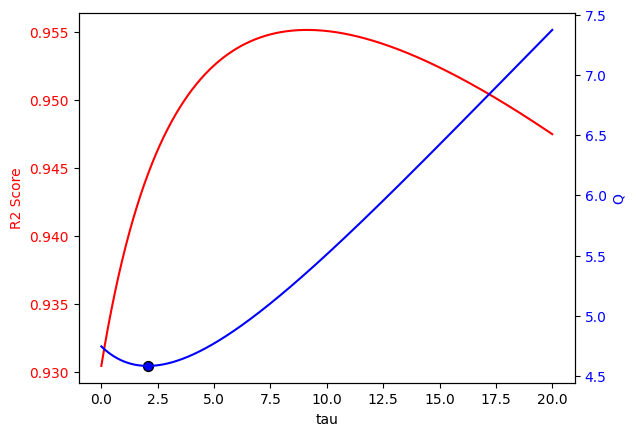

In [109]:
fig, ax1 = plt.subplots() 
color = 'red'
ax1.set_xlabel('tau') 
ax1.set_ylabel('R2 Score', color=color) 
ax1.plot(tau_range, r2_list, color=color) 
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 
color = 'blue'
ax2.set_ylabel('Q', color=color) 
ax2.plot(tau_range, q_list, color=color) 
ax2.scatter(best_tau, best_q, s=50, marker='o', color=color, edgecolor='k')
ax2.tick_params(axis ='y', labelcolor=color) 

plt.savefig("tau_optimization.png", bbox_inches="tight")

R2-score: 0.9445


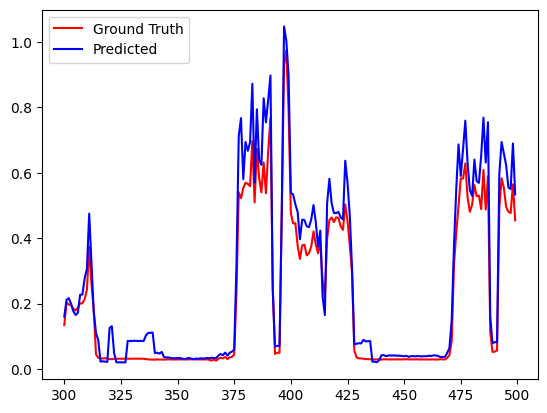

In [110]:
lr.best_weight = best_weights
y_pred = lr.predict(X_test)
print(f"R2-score: {r2_score(y_test, y_pred):.4f}")

plot_result(y_test, y_pred, (300, 500))
plt.savefig("compare_custom.png", bbox_inches="tight")

## Эталонная модель

In [111]:
from sklearn.linear_model import LinearRegression as LinearRegressionSklearn

model = LinearRegressionSklearn()
%timeit -n 10 -r 5 model.fit(X_train, y_train)

995 µs ± 174 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [112]:
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.9272249451679488

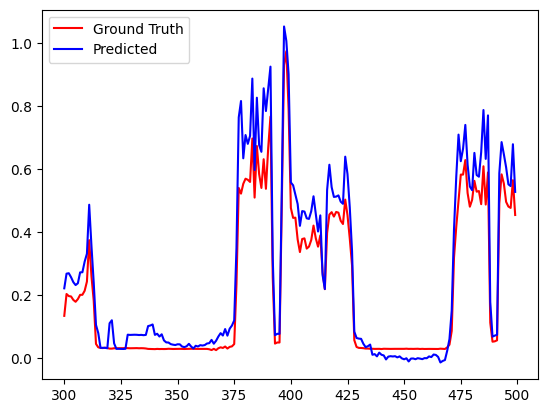

In [113]:
plot_result(y_test, y_pred, (300, 500))
plt.savefig("compare_sklearn.png", bbox_inches="tight")


## More data

In [97]:
idx = 15000
X_train = X[:idx]
y_train = y[:idx]

X_test = X[idx:idx+1000]
y_test = y[idx:idx+1000]

In [99]:
lr = LinearRegression(tau=0)
%timeit -n 1 -r 1 lr.fit(X_train, y_train)

y_pred_custom = lr.predict(X_test)
print(f"R2-score: {r2_score(y_test, y_pred_custom):.5f}")

model = LinearRegressionSklearn()
%timeit -n 10 -r 5 model.fit(X_train, y_train)
y_pred_sklearn = model.predict(X_test)
print(f"R2-score: {r2_score(y_test, y_pred_sklearn):.5f}")

7.03 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
R2-score: 0.98342
8.11 ms ± 1.09 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
R2-score: 0.98296
